# Environment

In [1]:
from cooler import Cooler, create_cooler

import higlass
from higlass.client import View, Track, CombinedTrack
from higlass.tilesets import cooler, beddb, chromsizes, bigwig, Tileset
import clodius
import os
import os.path as path
import pandas as pd
import numpy as np
import itertools
import negspy.coordinates as nc
import matplotlib.pyplot as plt
import scipy.stats as stats

## Load annotations

In [2]:
genes = beddb("../2019-10-24_higlass/Data/hg38/gene-annotations-hg38.beddb")
chrom_sizes = chromsizes("../2019-10-24_higlass/hg38.chrom.sizes")
label_font_size = 18
chr_label_size = 30
annots_size = 150

chrom_labels = {
    p: Track(
        track_type=l + "-chromosome-labels",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

gene_annots = {
    p: Track(
        track_type=l + "-gene-annotations",
        tileset=genes,
        position=p,
        height=annots_size,
        width=annots_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

hg38 = nc.get_chrominfo("hg38")

# Data
## Contact matrices

In [3]:
tumour_metadata = pd.read_csv(path.join("..", "..", "Data", "External", "LowC_Samples_Data_Available.tsv"), sep="\t", header=0)
tumour_metadata = tumour_metadata.loc[tumour_metadata.Include == "Yes", :]
tumour_metadata["SampleID"] = ["PCa" + str(i) for i in tumour_metadata["Sample ID"]]

tumour_samples = tumour_metadata["SampleID"].tolist()
t2e_samples = tumour_metadata.loc[tumour_metadata["T2E Status"] == "Yes", "SampleID"].tolist()
nont2e_samples = tumour_metadata.loc[tumour_metadata["T2E Status"] == "No", "SampleID"].tolist()

benign_metadata = pd.read_csv(path.join("..", "..", "Data", "Raw", "191220_A00827_0104_AHMW25DMXX_HiC", "config.tsv"), sep="\t", header=0)
benign_metadata = benign_metadata.loc[benign_metadata.Include == "Yes", :]
benign_samples = benign_metadata["Sample"].tolist()

cell_line_metadata = pd.read_csv(path.join("..", "..", "Data", "External", "Rhie_2019", "config.tsv"), sep="\t", header=0)
cell_line_samples = cell_line_metadata["Run_Accession"].tolist()

all_samples = tumour_samples + benign_samples + cell_line_samples
metadata = pd.read_csv(path.join("..", "2020-01-15_TAD-aggregation", "config.tsv"), sep="\t", index_col=False, header=0)
cooler_files = (
    [path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool") for s in tumour_samples + benign_samples]
    + [path.join("..", "..", "Data", "External", "Rhie_2019", "Contacts", s + ".mcool") for s in cell_line_samples]
)
lowc_tilesets = {s: cooler(f) for s, f in zip(all_samples, cooler_files)}

resolutions = [
    1000, 2000, 3000, 4000, 5000,
    10000, 20000, 30000, 40000, 50000,
    100000, 200000, 300000, 400000, 500000,
    1000000, 2000000, 3000000, 4000000, 5000000
][::-1]

min_resolution = 200000
heatmap_size = 500
colour_range = [
    "rgba(65, 105, 225, 1.0)",
    "rgba(255, 250, 250, 1.0)",
    "rgba(255, 25, 25, 1.0)"
]
lowc_heatmaps = {
    s: {
        p: Track(
            track_type=l + "heatmap",
            position=p,
            tileset=lowc_tilesets[s],
            filetype="cooler",
            height=heatmap_size,
            options={
                "maxZoom": str(resolutions.index(min_resolution)),
                "colorbarPosition": "topRight",
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0],
                "colorRange": colour_range,
            },
        ) for p, l in zip(
            ["top", "bottom", "left", "right", "center"],
            ["horizontal-", "horizontal-", "vertical-", "vertical-", ""]
        )
    } for s in all_samples
}

## TADs

In [4]:
windows = list(range(3, 21))
TRACK_DIR = "Tracks"

tad_1D_tilesets = {
    s: {
        w: beddb(
            path.join(TRACK_DIR, s + ".300000000.res_40000bp.window_" + str(w) + ".domains.beddb"),
            name=s + " TADs (w=" + str(w) +")"
        ) for w in windows
    } for s in tumour_samples + benign_samples
}

tads = {
    s: {
        w: {
           p: Track(
                track_type=t + "bedlike",
                position=p,
                tileset=tad_1D_tilesets[s][w],
                filetype="beddb",
                options={
                    "showMousePosition": True,
                    "name": "{} (w = {})".format(s, w),
                },
            ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
        } for w in windows
    } for s in tumour_samples + benign_samples
}

## Load breakpoints

In [5]:
BREAK_DIR = path.join("..", "2020-02-19_chromoplexy")
breaks = pd.read_csv(
    path.join(BREAK_DIR, "Graphs", "sv-breakpoints.paired.tsv"),
    sep="\t",
    header=0,
    index_col=False,
)

break_files_1D = {s: path.join(BREAK_DIR, "Tracks", s + ".breaks.beddb") for s in tumour_samples}
break_tilesets_1D = {
    s: beddb(
        v,
        name=metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " Breaks"
    ) for s, v in break_files_1D.items()
}
break_tracks_1D = {
    s: {
        p: Track(
            track_type=t + "bedlike",
            position=p,
            tileset=break_tilesets_1D[s],
            filetype="beddb",
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
    } for s in tumour_samples
}

disruption_tests = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-disruption-tests.tsv"), sep="\t")
bp_singletons = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-breakpoints.tsv"), sep="\t")
bp_pairs = pd.read_csv(path.join("..", "2020-02-19_chromoplexy", "Graphs", "sv-breakpoints.paired.tsv"), sep="\t")
disruption_tads = pd.read_csv(path.join("..", "2020-02-19_sv-disruption-TADs", "sv-disruption-tests.TADs.tsv"), sep="\t")

## H3K27ac ChIP-seq

In [6]:
TRACK_DIR = path.join("..", "..", "Data", "Processed", "2019-05-03_PCa-H3K27ac-peaks", "Tracks")
line_height = 150

peak_files = {s: path.join(TRACK_DIR, s + "_peaks.beddb") for s in tumour_samples}
peak_tilesets = {s: beddb(f) for s, f in peak_files.items()}
peaks = {
    s: {
        p: Track(
            track_type=t + "bedlike",
            position=p,
            tileset=ts,
            filetype="beddb",
            options={
                "showMousePosition": True,
                "name": metadata.loc[metadata["SampleID"] == s, "Label"].values[0] + " H3K27ac Peaks",
                "fillColor": metadata.loc[metadata["SampleID"] == s, "Sample_Colour"].values[0],
            },
        ) for p, t in zip(["top", "bottom", "left", "right"], ["", "", "vertical-", "vertical-"])
    } for s, ts in peak_tilesets.items()
}

# Effect of structural variants on TAD boundaries

## A structural variant that alters local TAD boundaries without changing gene expression

In [8]:
sv_sample_id = "PCa13848"
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 34499120, hg38),
        nc.chr_pos_to_genome_pos("chr14", 36927510, hg38),
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr21", 38390391, hg38),
        nc.chr_pos_to_genome_pos("chr21", 41642867, hg38)
    ]
}

v = View(
    tracks=[
        chrom_labels["top"],
        gene_annots["top"],
        chrom_labels["left"],
        gene_annots["left"],
        lowc_heatmaps[sv_sample_id]["top"],
        lowc_heatmaps[sv_sample_id]["center"],
    ],
    initialXDomain = pos["x"],
    initialYDomain = pos["y"],
)

d, s, c = higlass.display(
    views=[v],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'RlGFKpPbQ1qDMwzYOxRb-Q', 'tracks': {'top': [{'ty…

In [9]:
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 35400000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 35900000, hg38),
    ],
}

v = View(
    tracks=[
        chrom_labels["top"],
        gene_annots["top"],
    ],
    initialXDomain = pos["x"],
)

d, s, c = higlass.display(
    views=[v],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'IJUT8iZFQPWQ_LJrDXoJBA', 'tracks': {'top': [{'ty…

/home/james/miniconda3/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


{'nonmut': Ttest_indResult(statistic=6.378452174485695, pvalue=1.0394982648405165e-09), 'benign': Ttest_indResult(statistic=15.531784615377097, pvalue=8.75050100465106e-41)}


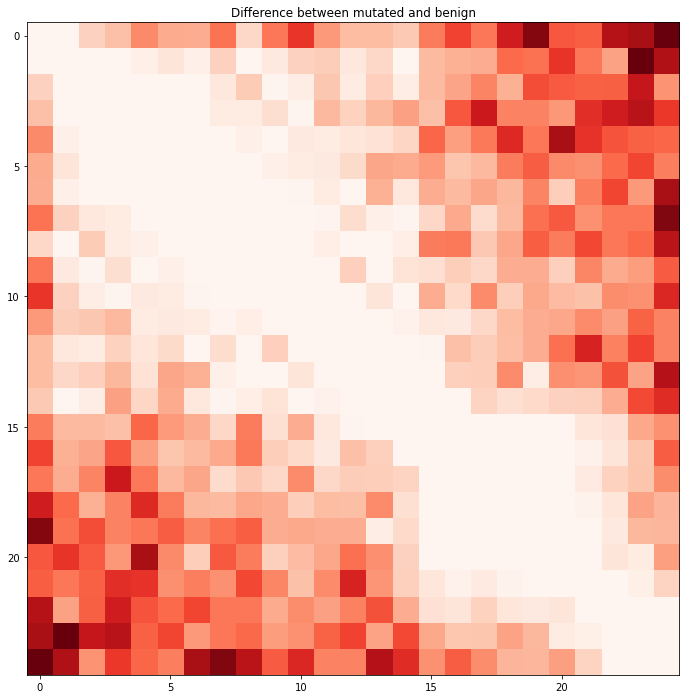

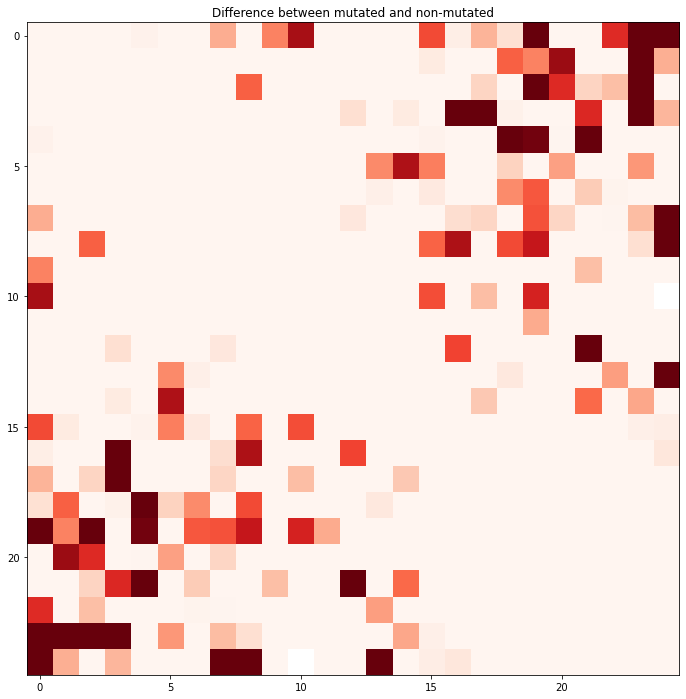

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

sv_sample_id = "PCa13848"
nonsv_sample_id = "PCa53687"
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 35225000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 36025000, hg38),
    ],
}

def filter_arr(x):
    return x[~np.isnan(x) & np.isfinite(x)]

mut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", sv_sample_id + ".mcool::/resolutions/20000"))
nonmut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", nonsv_sample_id + ".mcool::/resolutions/20000"))
benigns = {
    s: Cooler(
        path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool::/resolutions/20000")
    ) for s in benign_samples
}

# get contact matrix values around the breakpoint
i, j = mut.extent("chr14:35400000-35900000")
mut_mat = mut.matrix()[i:j, i:j]
nonmut_mat = nonmut.matrix()[i:j, i:j]
benign_mat = np.mean([benigns[s].matrix()[i:j, i:j] for s in benign_samples])

# calculate the difference between the two contact matrices
# (< 0: more contacts in mutant, > 0: fewer contacts in mutant)
diff = {
    "nonmut": np.log10(nonmut_mat / mut_mat),
    "benign": np.log10(benign_mat / mut_mat),
}

half_idx = (
    [(i, j) for i in range(16) for j in range(16) if j >= i]
    + [(i, j) for i in range(16, 25) for j in range(16, 25) if j >= i]
)
#print(half_idx)
#print(len(half_idx))
overlapping = {
    "nonmut": diff["nonmut"][[i for i, _ in half_idx], [j for _, j in half_idx]].flatten(),
    "benign": diff["benign"][[i for i, _ in half_idx], [j for _, j in half_idx]].flatten(),
}
broken = {
    "nonmut": diff["nonmut"][0:16, 16:].flatten(),
    "benign": diff["benign"][0:16, 16:].flatten(),
}

ttest_res = {
    "nonmut": stats.ttest_ind(
        a = filter_arr(broken["nonmut"]),
        b = filter_arr(overlapping["nonmut"]),
        equal_var=False,
    ),
    "benign": stats.ttest_ind(
        a = filter_arr(broken["benign"]),
        b = filter_arr(overlapping["benign"]),
        equal_var=False,
    ),
}
print(ttest_res)

# plot differences between mutant and nonmutant/benign samples
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and benign")
plt.imshow(diff["benign"], vmin=0, vmax=1.2, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-benign.altered-TAD.pdf")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and non-mutated")
plt.imshow(diff["nonmut"], vmin=0, vmax=0.3, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-nonmut.altered-TAD.pdf")

## A structural variant that does not affect local TAD boundaries with differential gene expression

In [10]:
# test_ID 311
sv_sample_id = "PCa58215"
nonsv_sample_id = "PCa13266"
print(disruption_tads.loc[disruption_tads.test_ID == 311, :])

pos = [
    {
        "x": [
            nc.chr_pos_to_genome_pos("chr12", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr12", 132000000, hg38)
        ],
        "y": [
            nc.chr_pos_to_genome_pos("chr12", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr12", 132000000, hg38)
        ]
    },
    {
        "x": [
            nc.chr_pos_to_genome_pos("chr12", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr12", 132000000, hg38)
        ],
        "y": [
            nc.chr_pos_to_genome_pos("chr7", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr7", 150000000, hg38)
        ]
    },
    {
        "x": [
            nc.chr_pos_to_genome_pos("chr7", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr7", 150000000, hg38)
        ],
        "y": [
            nc.chr_pos_to_genome_pos("chr7", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr7", 150000000, hg38)
        ]
    },
]
    
    
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chrom_labels["left"],
            gene_annots["left"],
            lowc_heatmaps[sv_sample_id]["center"],
        ],
        initialXDomain = pos[i]["x"],
        initialYDomain = pos[i]["y"],
    ) for i in range(3)
]

d, s, c = higlass.display(
    views=[v[0], v[2], v[1]],
    #value_scale_syncs=[
    #    [(v, lowc_heatmaps[sv_sample_id]["top"]), (v, lowc_heatmaps[nonsv_sample_id]["bottom"])]
    #]
)
d

     test_ID  altered_TAD    chr      start        end
258      311        False  chr12  128950000  130550000


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'IWTIVw73RS6hvejjbj4-_w', 'tracks': {'top': [{'ty…

In [9]:
# test_ID 311
sv_sample_id = "PCa58215"
nonsv_sample_id = "PCa13266"
print(disruption_tads.loc[disruption_tads.test_ID == 311, :])

pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr12", 79000000, hg38),
        nc.chr_pos_to_genome_pos("chr12", 133000000, hg38)
    ],
    "y": [
        nc.chr_pos_to_genome_pos("chr7", 92000000, hg38),
        nc.chr_pos_to_genome_pos("chr7", 154000000, hg38)
    ],
}
    
    
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chrom_labels["left"],
            gene_annots["left"],
            lowc_heatmaps[sv_sample_id]["center"],
        ],
        initialXDomain = pos["x"],
        initialYDomain = pos["y"],
    )
]

d, s, c = higlass.display(
    views=v,
)
d

     test_ID  altered_TAD    chr      start        end
258      311        False  chr12  128950000  130550000


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'ajoQHWIfSnSZddPr_C21uw', 'tracks': {'top': [{'ty…

(38, 38)
[-0.9771663892540651, 0.9238069449315305]
[-0.6160525891391898, 1.495763668793547]
325
325
169
169
{'nonmut': Ttest_indResult(statistic=0.8100675063907965, pvalue=0.41829300258798974), 'benign': Ttest_indResult(statistic=19.354682945577434, pvalue=1.8041400332171302e-62)}


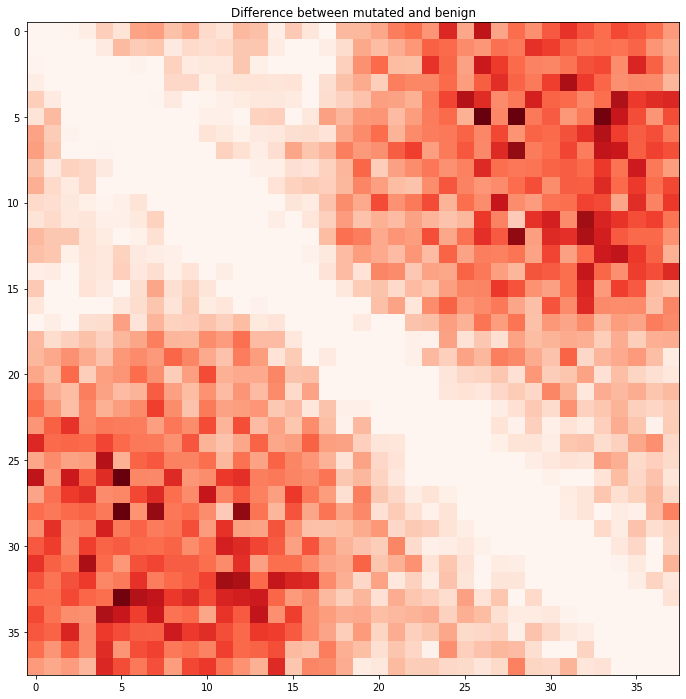

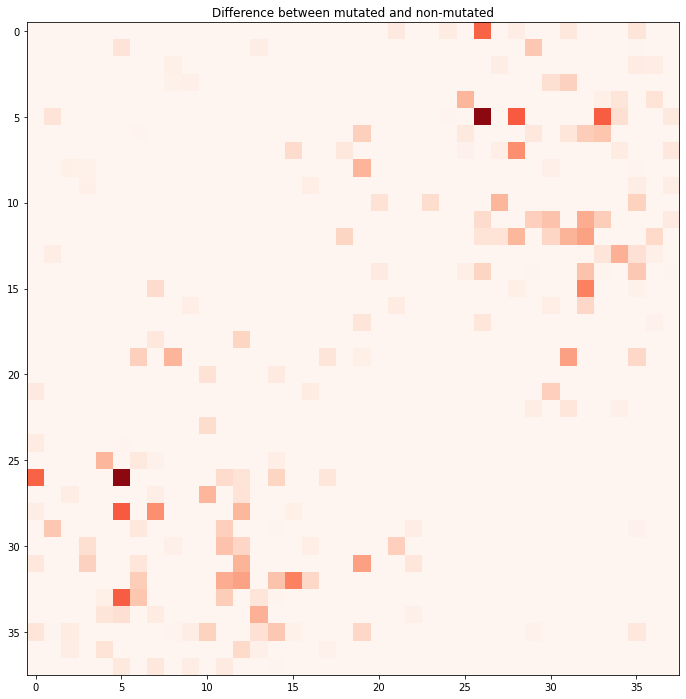

In [25]:
sv_sample_id = "PCa58215"
nonsv_sample_id = "PCa13266"

mut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", sv_sample_id + ".mcool::/resolutions/20000"))
nonmut = Cooler(path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", nonsv_sample_id + ".mcool::/resolutions/20000"))
benigns = {
    s: Cooler(
        path.join("..", "..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts", s + ".mcool::/resolutions/20000")
    ) for s in benign_samples
}

def filter_arr(x):
    return x[~np.isnan(x) & np.isfinite(x)]

# get contact matrix values around the breakpoint
i, j = mut.extent("chr12:130000000-130760000")
#i, j = mut.extent("chr12:129150000-129630000")
mut_mat = mut.matrix()[i:j, i:j]
nonmut_mat = nonmut.matrix()[i:j, i:j]
benign_mat = np.mean([benigns[s].matrix()[i:j, i:j] for s in benign_samples])

half_idx = (
    [(i, j) for i in range(13) for j in range(13) if j >= i]
    + [(i, j) for i in range(13, 25) for j in range(13, 25) if j >= i]
)

# calculate the difference between the two contact matrices
# (< 0: more contacts in mutant, > 0: fewer contacts in mutant)
diff = {
    "nonmut": np.log10(nonmut_mat / mut_mat),
    "benign": np.log10(benign_mat / mut_mat),
}
print(diff["nonmut"].shape)
print([filter_arr(diff["nonmut"]).min(), filter_arr(diff["nonmut"]).max()])
print([filter_arr(diff["benign"]).min(), filter_arr(diff["benign"]).max()])

overlapping = {
    "nonmut": diff["nonmut"][[i for i, _ in half_idx], [j for _, j in half_idx]].flatten(),
    "benign": diff["benign"][[i for i, _ in half_idx], [j for _, j in half_idx]].flatten(),
}
broken = {
    "nonmut": diff["nonmut"][0:13, 13:].flatten(),
    "benign": diff["benign"][0:13, 13:].flatten(),
}
print(len(broken["nonmut"]))
print(len(filter_arr(broken["nonmut"])))
print(len(overlapping["nonmut"]))
print(len(filter_arr(overlapping["nonmut"])))

ttest_res = {
    "nonmut": stats.ttest_ind(
        a = filter_arr(broken["nonmut"]),
        b = filter_arr(overlapping["nonmut"]),
    ),
    "benign": stats.ttest_ind(
        a = filter_arr(broken["benign"]),
        b = filter_arr(overlapping["benign"]),
    ),
}

print(ttest_res)


# plot differences between mutant and nonmutant/benign samples
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and benign")
plt.imshow(diff["benign"], vmin=0, vmax=1.2, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-benign.no-altered-TAD.pdf")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and non-mutated")
plt.imshow(diff["nonmut"], vmin=0, vmax=1, cmap="Reds")
ax.set_aspect('equal')
fig.savefig("diff-nonmut.no-altered-TAD.pdf")

In [23]:
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr12", 130000000, hg38),
        nc.chr_pos_to_genome_pos("chr12", 130760000, hg38)
    ],
}

v = View(
    tracks=[
        chrom_labels["top"],
        gene_annots["top"],
        #chrom_labels["left"],
        #gene_annots["left"],
        #lowc_heatmaps[sv_sample_id]["top"],
        #lowc_heatmaps[sv_sample_id]["center"],
    ],
    initialXDomain = pos["x"],
    #initialYDomain = pos["y"],
)

d, s, c = higlass.display(
    views=[v],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'W4GKMH50QI-ndHKbKXOf2Q', 'tracks': {'top': [{'ty…

## Exploring other breakpoints

In [11]:
zoom_offset = 1e6

# test_ID
ti = 19
# paired test_ID(s)
tj = bp_pairs.loc[bp_pairs.test_ID_x == ti, "test_ID_y"].tolist() + bp_pairs.loc[bp_pairs.test_ID_y == ti, "test_ID_x"].tolist()

# mutated sample IDs
mut_s = disruption_tests.loc[disruption_tests.test_ID == ti, "mut_samples"].values[0].split(",")
nonmut_s = disruption_tests.loc[disruption_tests.test_ID == ti, "nonmut_samples"].values[0].split(",")

# views
v = []
if len(tj) > 1:
    pos = {
        "x": {
            "chr": disruption_tads.loc[disruption_tads.test_ID == ti, "chr"].values[0],
            "start": int(disruption_tads.loc[disruption_tads.test_ID == ti, "start"].values[0]) - zoom_offset,
            "end": int(disruption_tads.loc[disruption_tads.test_ID == ti, "end"].values[0]) + zoom_offset,
        },
        "y": {
            k: {
                "chr": disruption_tads.loc[disruption_tads.test_ID == k, "chr"].values[0],
                "start": int(disruption_tads.loc[disruption_tads.test_ID == k, "start"].values[0]) - zoom_offset,
                "end": int(disruption_tads.loc[disruption_tads.test_ID == k, "end"].values[0]) + zoom_offset,
            } for k in tj
        },
    }
    v = [
        View(
            tracks=[
                chrom_labels["top"],
                gene_annots["top"],
                peaks[s]["top"],
                tads[s][20]["top"],
                chrom_labels["left"],
                gene_annots["left"],
                peaks[s]["left"],
                tads[s][20]["left"],
                lowc_heatmaps[s]["center"],
                gene_annots["bottom"],
            ],
            initialXDomain=[
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
            ],
            initialYDomain=[
                nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["end"], hg38)
            ],
        ) for s in mut_s for k in tj
    ]
    for s in nonmut_s[1:2]:
        for k in tj:
            v.append(View(
                tracks=[
                    chrom_labels["top"],
                    gene_annots["top"],
                    peaks[s]["top"],
                    tads[s][20]["top"],
                    chrom_labels["left"],
                    gene_annots["left"],
                    peaks[s]["left"],
                    tads[s][20]["left"],
                    lowc_heatmaps[s]["center"],
                    gene_annots["bottom"],
                ],
                initialXDomain=[
                    nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                    nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
                ],
                initialYDomain=[
                    nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["start"], hg38),
                    nc.chr_pos_to_genome_pos(pos["y"][k]["chr"], pos["y"][k]["end"], hg38)
                ],
            ))
else:
    pos = {
        "x": {
            "chr": disruption_tads.loc[disruption_tads.test_ID == ti, "chr"].values[0],
            "start": int(disruption_tads.loc[disruption_tads.test_ID == ti, "start"].values[0]) - zoom_offset,
            "end": int(disruption_tads.loc[disruption_tads.test_ID == ti, "end"].values[0]) + zoom_offset,
        },
        "y": {
            "chr": disruption_tads.loc[disruption_tads.test_ID == tj[0], "chr"].values[0],
            "start": int(disruption_tads.loc[disruption_tads.test_ID == tj[0], "start"].values[0]) - zoom_offset,
            "end": int(disruption_tads.loc[disruption_tads.test_ID == tj[0], "end"].values[0]) + zoom_offset,
        },
    }
    v = [
        View(
            tracks=[
                chrom_labels["top"],
                gene_annots["top"],
                peaks[s]["top"],
                tads[s][20]["top"],
                gene_annots["left"],
                chrom_labels["left"],
                peaks[s]["left"],
                tads[s][20]["left"],
                lowc_heatmaps[s]["center"],
                lowc_heatmaps[s]["bottom"],
                gene_annots["bottom"],
            ],
            initialXDomain=[
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
            ],
            initialYDomain=[
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["end"], hg38)
            ],
        ) for s in mut_s
    ]
    
    for s in nonmut_s[1:2]:
        v.append(View(
            tracks=[
                chrom_labels["top"],
                gene_annots["top"],
                peaks[s]["top"],
                tads[s][20]["top"],
                gene_annots["left"],
                chrom_labels["left"],
                peaks[s]["left"],
                tads[s][20]["left"],
                lowc_heatmaps[s]["center"],
                lowc_heatmaps[s]["bottom"],
                gene_annots["bottom"],
                gene_annots["bottom"],
            ],
            initialXDomain=[
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["x"]["chr"], pos["x"]["end"], hg38)
            ],
            initialYDomain=[
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["start"], hg38),
                nc.chr_pos_to_genome_pos(pos["y"]["chr"], pos["y"]["end"], hg38)
            ],
        ))


print(mut_s)
print(nonmut_s)
print(pos)
display, server, viewconf = higlass.display(
    views=v,
    zoom_syncs=[v],
#    location_syncs=[v],
#    value_scale_syncs=[
#        [(v[s], lowc_heatmaps[s]["top"]) for s in v]
#    ],
    server_port=8192
)

display

['PCa13848']
['PCa13266', 'PCa14121', 'PCa19121', 'PCa3023', 'PCa33173', 'PCa40507', 'PCa51852', 'PCa53687', 'PCa56413', 'PCa57294', 'PCa58215']
{'x': {'chr': 'chr5', 'start': 171300000.0, 'end': 174100000.0}, 'y': {'chr': 'chr5', 'start': 57900000.0, 'end': 60300000.0}}


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'Egt-QWKPTPCFtR1tLd3y1w', 'tracks': {'top': [{'ty…

# Images
## Important prostate cancer regions

In [10]:
sample_tracks = [chrom_labels["top"], gene_annots["top"]] + [lowc_heatmaps[s]["top"] for s in all_samples[::-1]]
tumour_tracks = [chrom_labels["top"], gene_annots["top"]] + [lowc_heatmaps[s]["top"] for s in tumour_samples]

### FOXA1

In [18]:
foxa1_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr14", 36000000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 39000000, hg38)
    ],
)

display, server, viewconf = higlass.display(
    [foxa1_view],
    value_scale_syncs=[
        [(foxa1_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'El1Cw0kTTritNvpESa4vrg', 'tracks': {'top': [{'ty…

In [20]:
print("This: {}".format(display.dom_element_id))
#save_as_png(display, path.join(os.getcwd(), "Plots", "FOXA1-locus.v2.png"))
save_as_png(display, path.join("Plots", "FOXA1-locus.v2.png"))

This: 0veffb


NameError: name 'save_as_png' is not defined

### _TMPRSS2 - ERG_ fusion

In [11]:
t2e_view = View(
    tracks=tumour_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr21", 35000000, hg38),
        nc.chr_pos_to_genome_pos("chr21", 43000000, hg38)
    ],
)

display, server, viewconf = higlass.display(
    views=[t2e_view],
    value_scale_syncs = [
        [(t2e_view, lowc_heatmaps[s]["top"]) for s in tumour_samples],
    ],
    #zoom_syncs=[
    #    [(t2e_view, lowc_heatmaps[s]["center"]) for s in tumour_samples],
    #],
    #location_syncs=[
    #    [(t2e_view, lowc_heatmaps[s]["center"]) for s in tumour_samples],
    #],
    server_port=8192
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'e9Lfnuv7SNSoaRv4Uz6Ulw', 'tracks': {'top': [{'ty…

### AR

In [23]:
ar_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chrX", 65800000, hg38),
        nc.chr_pos_to_genome_pos("chrX", 68700000, hg38)
    ]
)

display, server, viewconf = higlass.display(
    [ar_view],
    value_scale_syncs = [
        [(ar_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'JdyFubg-R2-66OQ1TFUxow', 'tracks': {'top': [{'ty…

### MYC

In [24]:
myc_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr8", 126000000, hg38),
        nc.chr_pos_to_genome_pos("chr8", 130000000, hg38)
    ],
)

display, server, viewconf = higlass.display(
    [myc_view],
    value_scale_syncs=[
        [(myc_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'SQ_PXsdOTaau3ltyrKoLlQ', 'tracks': {'top': [{'ty…

### HOXB13

In [25]:
hoxb13_view = View(
    tracks=sample_tracks,
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr17", 46160000, hg38),
        nc.chr_pos_to_genome_pos("chr17", 51320000, hg38)
    ],
)
display, server, viewconf = higlass.display(
    [hoxb13_view],
    value_scale_syncs=[
        [(hoxb13_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'XORqkA-4RxuSUVqkhmpf2A', 'tracks': {'top': [{'ty…

### KLK Cluster

In [12]:
klk_view = View(
    tracks=sample_tracks,
    #tracks = [chrom_labels["top"], gene_annots["top"]],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr19", 49000000, hg38),
        nc.chr_pos_to_genome_pos("chr19", 53000000, hg38)
    ],
)
display, server, viewconf = higlass.display(
    [klk_view],
    value_scale_syncs=[
        [(klk_view, lowc_heatmaps[s]["top"]) for s in all_samples]
    ],
    server_port=8192,
)
display


HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'coYkGqDnSiu23Z7eqM5Geg', 'tracks': {'top': [{'ty…

### MYC

In [ ]:
myc_insertion_view = View(
    tracks=[chrom_labels["top"], gene_annots["top"]] + [lowc_heatmaps[s]["top"] for s in all_samples],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr12", 70480000 - 5e6, hg38),
        nc.chr_pos_to_genome_pos("chr12", 70570000 + 5e6, hg38)
    ],
)

display, server, viewconf = higlass.display([
    myc_insertion_view
])
display